In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

Creating messy dataset

In [ ]:
np.random.seed(42)

n = 250
hours = np.random.normal(5, 2, n)

shape i/p dataset:  (250, 4)
Initial Data Snapshot:
    Hours_Studied  Attendance  Previous_Score  Pass
0       5.993428   62.391160       73.892663     0
1       4.723471   84.178619       88.641250     0
2       6.295377   96.221562       39.021486     0
3       8.046060   85.324653       68.444539     0
4       4.531693   59.806300       50.240361     0
5      50.000000   70.157659       52.693119     0
6       8.158426   87.669111      200.000000     0
7       6.534869   67.923305       47.040138     0
8       4.061051   79.438194       60.727824     0
9       6.085120   82.746341       47.535748     0

Duplicate rows: 5

Missing values before handling:
 Hours_Studied     6
Attendance        6
Previous_Score    6
Pass              0
dtype: int64

Missing values after handling:
 Hours_Studied     0
Attendance        0
Previous_Score    0
Pass              0
dtype: int64


/var/folders/v8/5mnjqwh57kq67kb_f_4xbn3w0000gn/T/ipykernel_51660/819399292.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Hours_Studied"].fillna(df["Hours_Studied"].median(), inplace=True)
/var/folders/v8/5mnjqwh57kq67kb_f_4xbn3w0000gn/T/ipykernel_51660/819399292.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

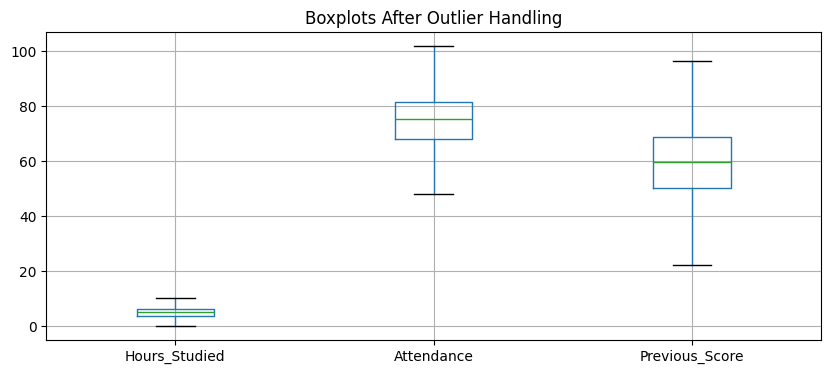

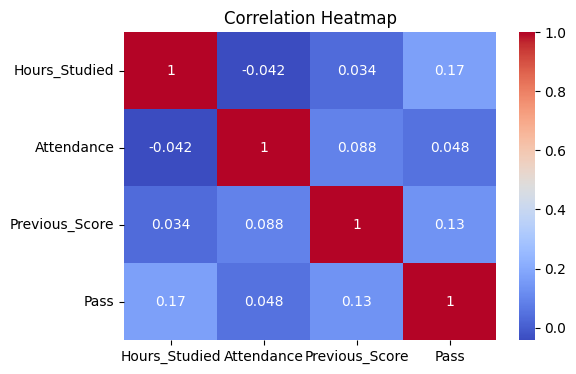


Train size: 150, Val: 50, Test: 50

Model Coefficients:
Intercept: -9.342594326568678
Hours_Studied: 0.2757
Attendance: 0.0364
Previous_Score: 0.0478

Validation Evaluation:
  Accuracy  = 0.8600
  Precision = 0.0000
  Recall    = 0.0000
  F1 Score  = 0.0000
  Confusion Matrix:
 [[43  1]
 [ 6  0]]

Test Evaluation:
  Accuracy  = 0.8800
  Precision = 0.0000
  Recall    = 0.0000
  F1 Score  = 0.0000
  Confusion Matrix:
 [[44  0]
 [ 6  0]]


/Users/jhod/opt/anaconda3/envs/learn-llm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


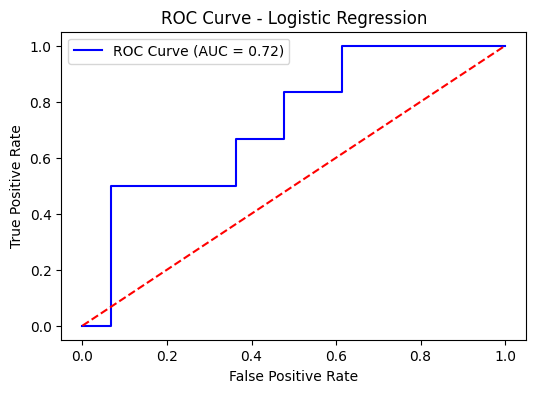

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# -----------------------------
# Step 1: Create messy dataset
# -----------------------------
np.random.seed(42)

n = 250
hours = np.random.normal(5, 2, n)
attendance = np.random.normal(75, 10, n)
previous_score = np.random.normal(60, 15, n)

# True probability of passing depends on features
prob_pass = 1 / (1 + np.exp(-(0.3*hours + 0.05*attendance + 0.04*previous_score - 10)))
pass_fail = np.random.binomial(1, prob_pass)

df = pd.DataFrame({
    "Hours_Studied": hours,
    "Attendance": attendance,
    "Previous_Score": previous_score,
    "Pass": pass_fail
})
print("shape i/p dataset: ",df.shape)
# Add duplicates
df = pd.concat([df, df.iloc[:5]], ignore_index=True)

# Add missing values
df.loc[10:15, "Hours_Studied"] = np.nan
df.loc[20:25, "Attendance"] = np.nan
df.loc[30:35, "Previous_Score"] = np.nan

# Add outliers
df.loc[5, "Hours_Studied"] = 50
df.loc[6, "Previous_Score"] = 200

print("Initial Data Snapshot:\n", df.head(10))

# -----------------------------
# Step 2: EDA & Data Cleaning
# -----------------------------
#.
# 1. Check duplicates
print("\nDuplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()

# 2. Check missing values
print("\nMissing values before handling:\n", df.isnull().sum())

# Fill missing values
df["Hours_Studied"].fillna(df["Hours_Studied"].median(), inplace=True)
df["Attendance"].fillna(df["Attendance"].mean(), inplace=True)
df["Previous_Score"].fillna(df["Previous_Score"].mean(), inplace=True)

print("\nMissing values after handling:\n", df.isnull().sum())

# 3. Handle outliers using IQR
def handle_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    df[col] = np.where(df[col] > upper, upper,
                       np.where(df[col] < lower, lower, df[col]))

for col in ["Hours_Studied", "Attendance", "Previous_Score"]:
    handle_outliers(col)

# Quick check
plt.figure(figsize=(10,4))
df[["Hours_Studied","Attendance","Previous_Score"]].boxplot()
plt.title("Boxplots After Outlier Handling")
plt.show()

# 4. Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# -----------------------------
# Step 3: Train-Validation-Test Split
# -----------------------------
X = df[["Hours_Studied", "Attendance", "Previous_Score"]]
y = df["Pass"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nTrain size: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# -----------------------------
# Step 4: Logistic Regression Model
# -----------------------------
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("\nModel Coefficients:")
print("Intercept:", model.intercept_[0])
for col, coef in zip(X.columns, model.coef_[0]):
    print(f"{col}: {coef:.4f}")

# -----------------------------
# Step 5: Evaluation
# -----------------------------
def evaluate(model, X, y, dataset_name):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)

    print(f"\n{dataset_name} Evaluation:")
    print(f"  Accuracy  = {acc:.4f}")
    print(f"  Precision = {prec:.4f}")
    print(f"  Recall    = {rec:.4f}")
    print(f"  F1 Score  = {f1:.4f}")
    print("  Confusion Matrix:\n", cm)

# Evaluate on validation and test
evaluate(model, X_val, y_val, "Validation")
evaluate(model, X_test, y_test, "Test")

# -----------------------------
# Step 6: ROC Curve
# -----------------------------
y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()
